# Загрузка данных

In [ ]:
import pandas as pd

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# 📌 Аутентификация
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd

# 📡 Авторизация через Google Colab
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import regex as re  # используем расширенную поддержку emoji

# 📌 Определяем группы реакций
POSITIVE_EMOJIS = ["❤️", "🥰", "🔥", "💯", "🙏"]
NEGATIVE_EMOJIS = ["🤬", "😡", "😢", "😭", "😱", "🤯"]
NEUTRAL_EMOJIS  = ["🤔", "🤡", "🤨", "🤣", "✍"]

# 📥 Загрузка и обработка таблицы
def load_filtered_posts(sheet_name, platform_label):
    sheet = gc.open(sheet_name).sheet1
    data = sheet.get_all_records()
    df = pd.DataFrame(data)

    # Шаблон для Unicode-эмодзи
    emoji_pattern = re.compile(r'^\p{Emoji}+$', flags=re.UNICODE)

    # Выделяем emoji-столбцы (Telegram)
    emoji_cols = [col for col in df.columns if emoji_pattern.match(col)]

    # Если платформа Telegram — группируем реакции
    if platform_label == "ТГ":
        for emoji in POSITIVE_EMOJIS + NEGATIVE_EMOJIS + NEUTRAL_EMOJIS:
            if emoji not in df.columns:
                df[emoji] = 0  # если каких-то эмодзи нет в колонках, добавляем

        df["positive_reactions"] = df[POSITIVE_EMOJIS].sum(axis=1)
        df["negative_reactions"] = df[NEGATIVE_EMOJIS].sum(axis=1)
        df["neutral_reactions"]  = df[NEUTRAL_EMOJIS].sum(axis=1)
        df["total_reactions"] = df["positive_reactions"] + df["negative_reactions"] + df["neutral_reactions"]

        # Удаляем индивидуальные emoji-столбцы
        df.drop(columns=emoji_cols, inplace=True)

    # Если платформа VK — добавляем столбцы для согласования
    if platform_label == "ВК":
        df["positive_reactions"] = df.get("Лайки", 0).fillna(0)
        df["negative_reactions"] = 0
        df["neutral_reactions"] = 0
        df["total_reactions"] = df["positive_reactions"]

    # Добавляем колонку "Площадка"
    df.insert(0, "Площадка", platform_label)

    return df

In [ ]:
# 🗂 Загрузка обеих таблиц
vk_df = load_filtered_posts("vk_filtered_posts", "ВК")
tg_df = load_filtered_posts("tg_filtered_posts", "ТГ")

# 🧩 Объединение
df = pd.concat([vk_df, tg_df], ignore_index=True)

# ✅ Проверка результата
df


,Площадка,Канал,Тип медиа,ID,Дата,Текст,Просмотры,Ответы,Форварды,Лайки,positive_reactions,negative_reactions,neutral_reactions,total_reactions,❤‍🔥,❤️
0,ВК,tomsawyerfest,Тематический паблик,5893,2025-04-18 14:48:16,Ходите и чаще оглядывайтесь! Потому что сегод...,3651,6,7,98.0,98,0,0,98,NaN,NaN
1,ВК,tomsawyerfest,Тематический паблик,5741,2024-11-26 18:28:02,[id31565028|Myachina Ekaterina] - самарская ху...,2612,0,6,73.0,73,0,0,73,NaN,NaN
2,ВК,tomsawyerfest,Тематический паблик,5699,2024-11-12 16:06:56,Просим распространить информацию. 11 ноября в ...,8303,14,52,340.0,340,0,0,340,NaN,NaN
3,ВК,tomsawyerfest,Тематический паблик,5581,2024-10-16 16:30:00,Вы готовы стать Мастерами деревянных наличнико...,2173,3,30,113.0,113,0,0,113,NaN,NaN
4,ВК,tomsawyerfest,Тематический паблик,5454,2024-09-10 16:00:01,"Всем, кому дело есть до города! Не спите вы! ...",2970,1,10,101.0,101,0,0,101,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,ТГ,Fedorischev63,ОВ,1309,2024-11-14 15:17,Сегодня в Самарской области с визитом главный ...,57225,0,490,NaN,64,22,61,147,0.0,0.0
323,ТГ,save_as_samara,Тематический паблик,75,2023-01-23 6:27,Номинация 6. Фокус внимания - премия собствен...,99,0,1,NaN,0,0,0,0,0.0,0.0
324,ТГ,save_as_samara,Тематический паблик,68,2023-01-23 6:26,Номинация 5. Фокус внимания Дом с часами - д...,78,0,1,NaN,0,0,0,0,0.0,0.0
325,ТГ,save_as_samara,Тематический паблик,61,2023-01-23 6:24,Номинация 4. История в деталях - за реализован...,75,0,0,NaN,0,0,0,0,0.0,0.0


# Выбор самых резонансных постов для ручной обработки

In [ ]:
# Шаг 1. Создаём новую метрику: отношение числа форвардов к числу просмотров
df["Резонанс"] = df["Форварды"] / df["Просмотры"]

# Шаг 2. Вычисляем медиану этой метрики
quantile_ratio = df["Резонанс"].quantile(0.8)

# Шаг 3. Отбираем посты, у которых метрика выше медианной
top_df = df[df["Резонанс"] > quantile_ratio].copy()

# Шаг 4. Оставляем только нужные колонки (по желанию можно убрать этот шаг)
top_df = top_df[[
    "Дата", "Канал", "Тип медиа", "ID", "Текст", "Просмотры", "Форварды", "Резонанс", "positive_reactions",	"negative_reactions",	"neutral_reactions",	"total_reactions"
]]


In [ ]:
top_df.sort_values("Резонанс", ascending=False)

,Дата,Канал,Тип медиа,ID,Текст,Просмотры,Форварды,Резонанс,positive_reactions,negative_reactions,neutral_reactions,total_reactions
95,2024-06-04 9:09:32,voopiik_samara,ОВ,420,Вот так оценил отставку губернатора Дмитрия Аз...,1137,26,0.022867,83,0,0,83
106,2023-03-25 3:52:19,voopiik_samara,ОВ,200,Пожар в Челышёвском доме (объект культурного н...,1485,27,0.018182,81,0,0,81
67,2025-05-26 13:11:54,voopiik_samara,ОВ,783,28 мая в 19.00 в Доме архитектора пройдет лекц...,1090,19,0.017431,62,0,0,62
272,2021-08-20 7:42,truekpru63,СМИ,518,Это дом 126 по улице Степана Разина в Самаре. ...,119,2,0.016807,0,0,0,0
86,2024-10-24 11:22:13,voopiik_samara,ОВ,580,📹ТРАНСЛЯЦИЯ СЪЕЗДА В ЗАПИСИ Все заседания XXI...,702,11,0.015670,18,0,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...
6,2024-08-29 13:08:59,tomsawyerfest,Тематический паблик,5412,"""Том Сойер Фест"" проведет тематические МАСТЕР-...",2802,16,0.005710,131,0,0,131
76,2025-02-16 13:51:08,voopiik_samara,ОВ,674,"Друзья, у нас хорошие новости! Администрация г...",1929,11,0.005702,132,0,0,132
243,2023-10-05 16:20:52,Анастасия Кнор,Личные медиа,126,"Друзья, прошу внимания и репоста. В этом году ...",2823,16,0.005668,125,0,0,125
171,2022-08-03 9:06:05,Андрей Кочетков,Личные медиа,39655,Наш музей выиграл грант [club82285691|Благотво...,6536,36,0.005508,392,0,0,392


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Задаём путь к нужной папке на Google Диске
file_path = "/content/drive/MyDrive/топ_0.8_code_export.csv"

# Сохраняем файл
top_df.to_csv(file_path, index=False, encoding='utf-8-sig')


Mounted at /content/drive


# Анализ топовых по резонансу постов после ручной обработки (текстовый формат + визуализации)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
# Путь к CSV файлу на Google Drive
file_path = '/content/drive/MyDrive/топ_0.8_вручную.csv'

# Чтение CSV в DataFrame
df_tags = pd.read_csv(file_path)

# Просмотр первых строк
df_tags.head()


,Дата,Канал,Тип медиа,ID,Текст,Просмотры,Форварды,Резонанс,тематики,Unnamed: 9
0,2024-11-12 16:06:56,tomsawyerfest,Тематический паблик,5699,Просим распространить информацию. 11 ноября в ...,8303.0,52.0,"0,02286719437",снос; дом Кожевникова; обвинение,NaN
1,2024-10-16 16:30:00,tomsawyerfest,Тематический паблик,5581,Вы готовы стать Мастерами деревянных наличнико...,2173.0,30.0,"0,01818181818",МК; дом Кожевникова,NaN
2,2024-08-29 13:08:59,tomsawyerfest,Тематический паблик,5412,"""Том Сойер Фест"" проведет тематические МАСТЕР-...",2802.0,16.0,"0,01743119266",МК; дом Кожевникова,NaN
3,2023-08-07 14:20:00,tomsawyerfest,Тематический паблик,4212,"В эту пятницу, 11 августа, мы приглашаем желаю...",1752.0,12.0,"0,01680672269",МК; дом Кожевникова,NaN
4,2023-07-25 15:24:26,tomsawyerfest,Тематический паблик,4101,"Друзья, в скором времени мы начинаем очень инт...",2630.0,22.0,"0,01566951567",МК; дом Кожевникова,NaN


In [ ]:
# Извлекаем уникальные теги
all_tags = df_tags['тематики'].dropna().str.split('; ').explode()

# Удаляем возможные пустые строки и делаем теги уникальными
unique_tags = all_tags[all_tags != ''].unique()

# Выводим результат
print("Уникальные теги:")
for tag in sorted(unique_tags):
    print(f"- {tag}")

Уникальные теги:
- 4 ГПЗ
- cохранен памятник
- Дом Горького
- Дом Гребежева
- Корпус солдатских казарм
- Красноармейская, 11
- Кухмистерская Фон Вакано
- МК
- НПА
- Ново-буянская школа
- Особняк Субботина-Шихобалова
- Хлебзавод №2
- аварийное жилье
- адаптация памятников для коммерции
- дом Буянихи
- дом Кожевникова
- дом Репина
- дом с атлантами
- дом сивре
- дом у Струковского
- дом челышева
- изъятие для муниципальных нужд
- инициативы по сохранению памятников
- историческое поселение
- история
- консолидация сообщества
- кухмистерская фон вакано
- мероприятие
- обвинение
- препятствование со стороны ОВ
- расселение
- реальное училище
- самарская хоральная синагога
- сговор ОВ и застройщиков
- снос
- содействие со стороны ОВ
- угроза утраты
- элеватор


## Частотный анализ уникальных тегов

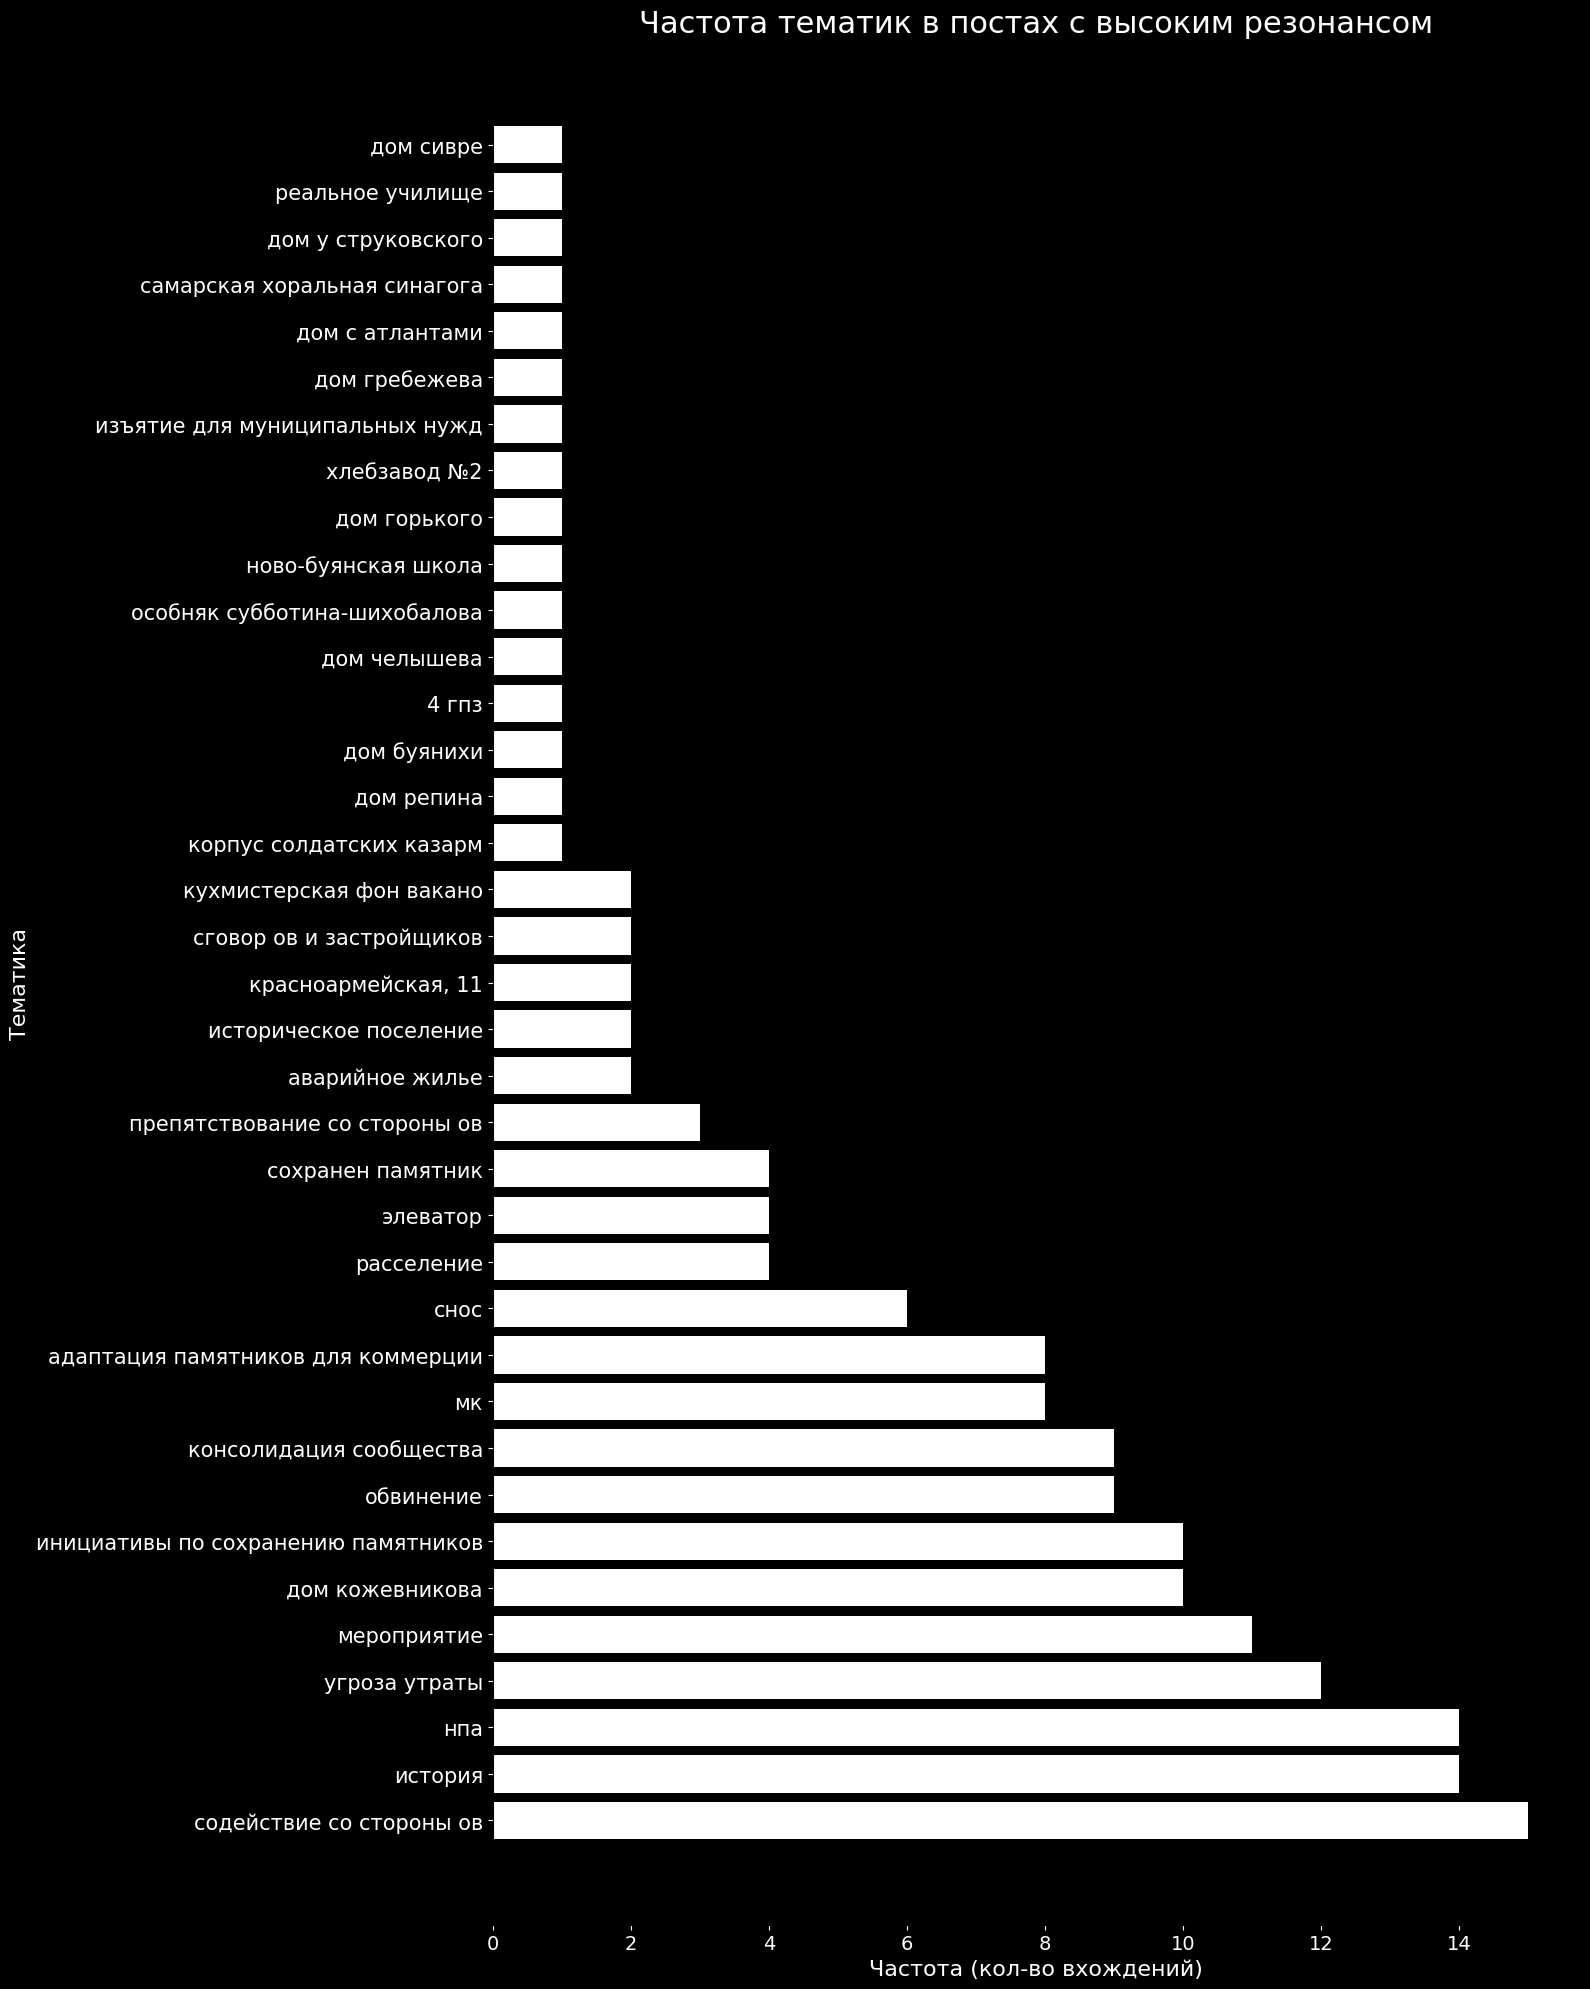

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Безопасный шрифт для Colab
plt.rcParams['font.family'] = 'DejaVu Sans'

# Подготовка данных
tags = df_tags['тематики'].dropna()
tags = tags.str.replace(r'\s+', ' ', regex=True).str.lower()
tags = tags.str.split('; ').explode()
tag_counts = Counter(tags)

# Сортировка по частоте
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)
tags_sorted, counts_sorted = zip(*sorted_tags)

# Увеличиваем высоту графика (figsize): 16 — ширина, 20 — высота
fig, ax = plt.subplots(figsize=(16, 20))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Построение bar chart
bars = ax.barh(tags_sorted, counts_sorted, color='white')

# Заголовки и подписи осей
ax.set_title('Частота тематик в постах с высоким резонансом', fontsize=22, color='white')
ax.set_xlabel('Частота (кол-во вхождений)', fontsize=16, color='white')
ax.set_ylabel('Тематика', fontsize=16, color='white')

# Увеличиваем размер шрифта у меток по оси Y
ax.tick_params(axis='x', colors='white', labelsize=14)
ax.tick_params(axis='y', colors='white', labelsize=15)  # вот тут больше

# Отступы
plt.subplots_adjust(left=0.35, right=0.95, top=0.95, bottom=0.05)
plt.tight_layout()
plt.show()


### Результаты частотного анализа в текствоом формате

In [ ]:
# 2. Извлечение всех тегов
all_tags = []

for tags in df_tags['тематики'].dropna():
    if isinstance(tags, str):
        # Разделяем строку по "; " и очищаем от лишних пробелов
        tags_list = [tag.strip() for tag in tags.split('; ') if tag.strip()]
        all_tags.extend(tags_list)

# 3. Подсчёт частотности тегов
tag_counts = Counter(all_tags)

# 4. Сортировка по убыванию частоты
sorted_tag_counts = sorted(tag_counts.items(), key=lambda x: -x[1])

# 5. Вывод результатов
print("Частотность тегов (по убыванию):")
for tag, count in sorted_tag_counts:
    print(f"{tag}: {count}")

Частотность тегов (по убыванию):
содействие со стороны ОВ: 15
история: 14
НПА: 14
угроза утраты: 12
мероприятие: 11
дом Кожевникова: 10
инициативы по сохранению памятников: 10
обвинение: 9
консолидация сообщества: 9
МК: 8
адаптация памятников для коммерции: 8
снос: 6
расселение: 4
элеватор: 4
cохранен памятник: 4
препятствование со стороны ОВ: 3
аварийное жилье: 2
историческое поселение: 2
Красноармейская, 11: 2
сговор ОВ и застройщиков: 2
Корпус солдатских казарм: 1
дом Репина: 1
дом Буянихи: 1
4 ГПЗ: 1
дом челышева: 1
Особняк Субботина-Шихобалова: 1
Кухмистерская Фон Вакано: 1
Ново-буянская школа: 1
Дом Горького: 1
Хлебзавод №2: 1
изъятие для муниципальных нужд: 1
Дом Гребежева: 1
дом с атлантами: 1
самарская хоральная синагога: 1
дом у Струковского: 1
реальное училище: 1
дом сивре: 1
кухмистерская фон вакано: 1


## Ассоциативный анализ

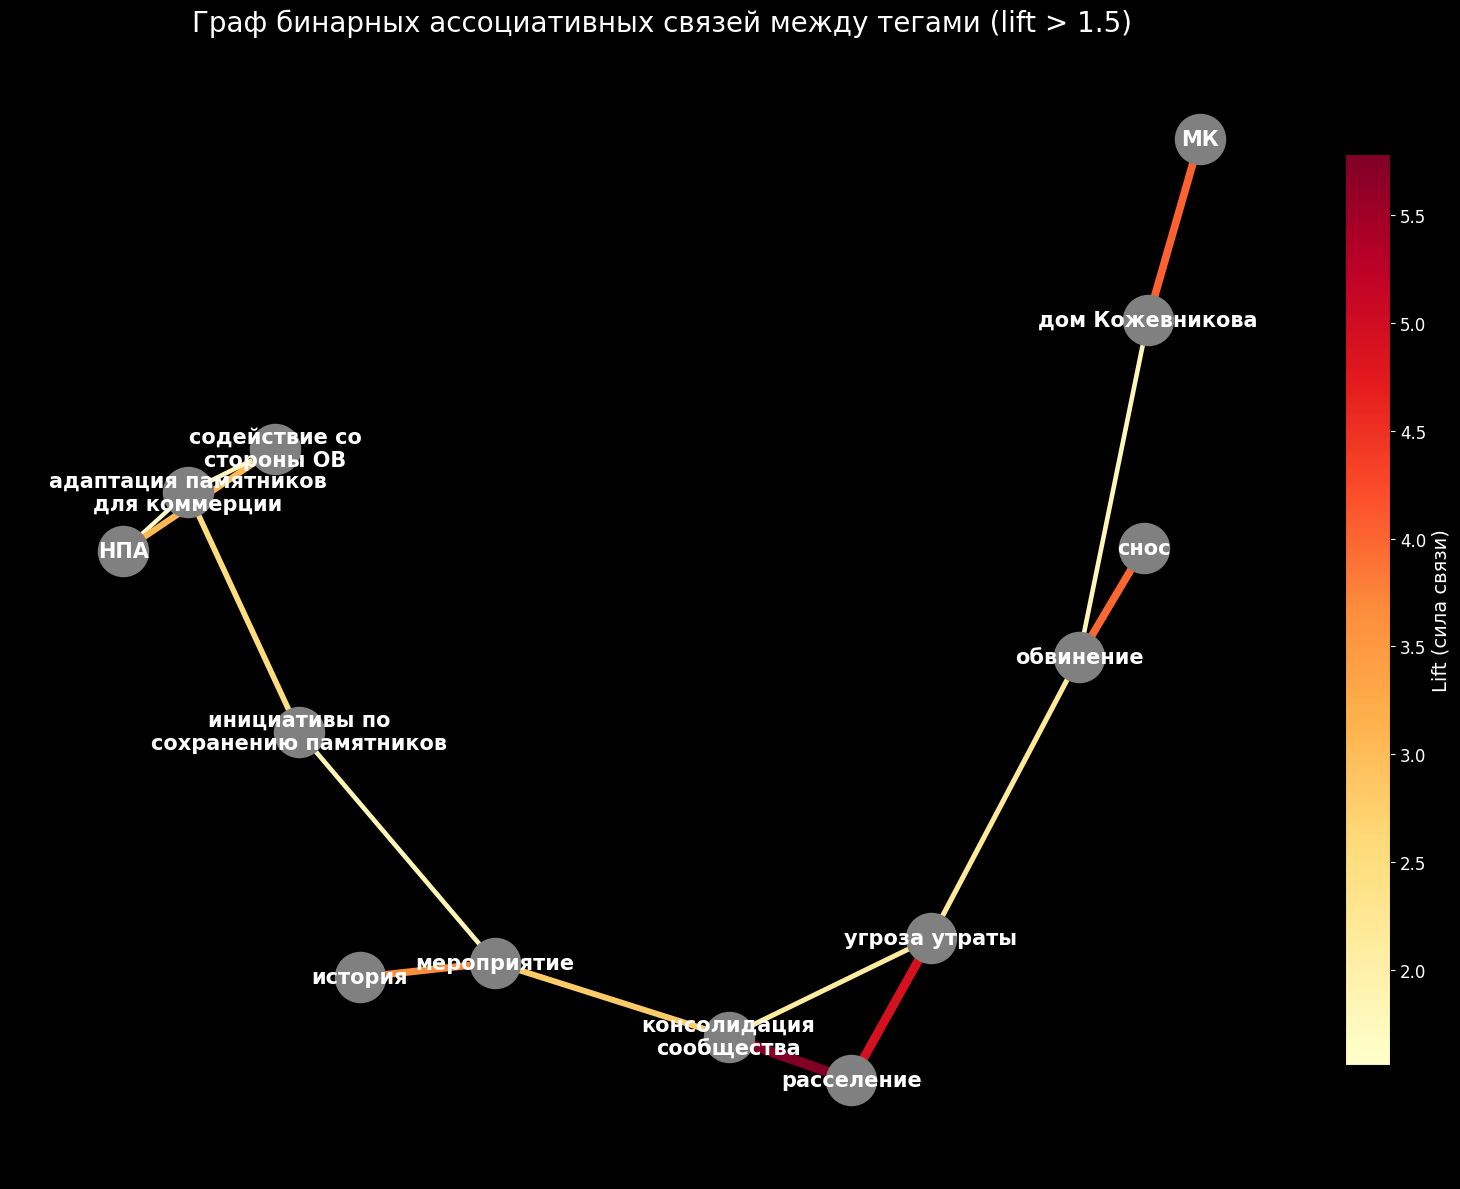

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# === Подготовка тегов ===
tags_list = []
for tags in df_tags['тематики'].dropna():
    if isinstance(tags, str):
        tags = tags.replace('...', '').strip()
        cleaned_tags = [tag.strip() for tag in tags.split('; ') if tag.strip()]
        if len(cleaned_tags) > 1:
            tags_list.append(cleaned_tags)

te = TransactionEncoder()
te_ary = te.fit(tags_list).transform(tags_list)
df_hot = pd.DataFrame(te_ary, columns=te.columns_)

# === Частые наборы и правила ===
frequent_itemsets = apriori(df_hot, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

# === Только бинарные правила
rules = rules[(rules['antecedents'].apply(len) == 1) & (rules['consequents'].apply(len) == 1)]

# === Построение графа
G = nx.Graph()
for _, row in rules.iterrows():
    a = list(row['antecedents'])[0]
    c = list(row['consequents'])[0]
    lift = row['lift']
    G.add_edge(a, c, weight=lift)

# === Размещение и центрирование
pos = nx.spring_layout(G, seed=42, k=1.2, iterations=100)
x_mean = np.mean([coord[0] for coord in pos.values()])
y_mean = np.mean([coord[1] for coord in pos.values()])
for n in pos:
    pos[n][0] -= x_mean
    pos[n][1] -= y_mean

# === Обработка меток узлов
new_labels = {}
for node in G.nodes():
    if len(node) > 20:
        words = node.split()
        midpoint = len(words) // 2
        new_labels[node] = ' '.join(words[:midpoint]) + '\n' + ' '.join(words[midpoint:])
    else:
        new_labels[node] = node

# === Подготовка визуализации
edges = G.edges(data=True)
weights = [d['weight'] for _, _, d in edges]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.colormaps.get_cmap("YlOrRd")
edge_colors = [cmap(norm(w)) for w in weights]

# === Визуализация графа
fig, ax = plt.subplots(figsize=(16, 12))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
nx.draw_networkx_nodes(G, pos, node_color='gray', node_size=1300, ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
                       width=[1.5 + w for w in weights], ax=ax)
nx.draw_networkx_labels(G, pos, labels=new_labels, font_size=15,
                        font_weight='bold', font_color='white', ax=ax)

# === Цветовая шкала
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(weights)
cbar = fig.colorbar(sm, ax=ax, pad=0.02, shrink=0.8)
cbar.set_label('Lift (сила связи)', fontsize=14, color='white')
cbar.ax.tick_params(labelsize=12, colors='white')

ax.set_title("Граф бинарных ассоциативных связей между тегами (lift > 1.5)", fontsize=20, color='white')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.axis('off')
plt.tight_layout()
plt.show()


### Результаты ассоциативного анализа в текстовом формате

In [7]:
# Отобразить только нужные столбцы, округлить значения
rules_to_print = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
rules_to_print['support'] = rules_to_print['support'].round(3)
rules_to_print['confidence'] = rules_to_print['confidence'].round(3)
rules_to_print['lift'] = rules_to_print['lift'].round(2)

# Преобразуем множества в читаемые строки
rules_to_print['antecedents'] = rules_to_print['antecedents'].apply(lambda x: ', '.join(x))
rules_to_print['consequents'] = rules_to_print['consequents'].apply(lambda x: ', '.join(x))

# Вывод в текстовом виде (можно скопировать и вставить)
print(rules_to_print.to_string(index=False))


                        antecedents                         consequents  support  confidence  lift
                    дом Кожевникова                                  МК    0.111       0.600  4.05
                                 МК                     дом Кожевникова    0.111       0.750  4.05
                                НПА  адаптация памятников для коммерции    0.056       0.231  1.56
 адаптация памятников для коммерции                                 НПА    0.056       0.375  1.56
                                НПА            содействие со стороны ОВ    0.204       0.846  3.05
           содействие со стороны ОВ                                 НПА    0.204       0.733  3.05
инициативы по сохранению памятников  адаптация памятников для коммерции    0.056       0.375  2.53
 адаптация памятников для коммерции инициативы по сохранению памятников    0.056       0.375  2.53
 адаптация памятников для коммерции            содействие со стороны ОВ    0.074       0.500  1.80
          